This script reads the precipitation data from an Excel .xlsx-file with daily accumulated precipitation in the unit m/day and transforms it into mm/day. The Excel file must only contain two columns, one with date and time and the other with the values. It then exports the data to a new Excel file.

In [ ]:
# Add libraries

import numpy as np
import pandas as pd

# Read precipitation data

# Precipitation (Read it as m/day)
file_path=input("Enter the file path to the precipitation data: ")                          # Manually enter the file path to the data
prec = pd.read_excel(file_path, parse_dates=True, index_col=0, names=['prec']).squeeze()    # Read data in m/day
prec = prec * 1000                                                                          # Transform to mm/day       
print(prec.head())                                                                          # Prints the first values

# Export the adjusted precipitation data to an Excel file
output_file_path = '2_data_processing/2.1_precipitation_data/precipitation_data.xlsx'
prec.to_excel(output_file_path, header=True)

print(f"Adjusted precipitation data has been saved to {output_file_path}")

Model to estimate groundwater levels with Pastas

Created by Joaquim Altimiras Granel 2024-02

Model information:
- Recharge model: FlexModel (non-linear) used as stress model
- Solver: LeastSquares
- Noise: False
- With snow. Compares the same model with and without snow.
- NO gw_uptake

In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps

## First step: Load all the data

In [2]:
# Loading data

# Groundwater head observations
# Input path to the head observations, DAILY
file_path=input("Enter the path to the head observations: ")
ho = pd.read_excel(file_path, usecols=[0, 1], index_col=0, parse_dates=True).squeeze()

# If you want to name the column "H" as 'head', you can rename it after reading.
ho.name = 'ho'

#ho = pd.read_excel(file_path, parse_dates=True, index_col=0, names=['head']).squeeze()
print("The data type of the oseries is:", type(ho))
print(ho.head())

The data type of the oseries is: <class 'pandas.core.series.Series'>
Date/time
2022-12-22    144.533318
2022-12-23    144.557483
2022-12-24    144.581954
2022-12-25    144.572572
2022-12-26    144.545014
Name: ho, dtype: float64


In [3]:
# Read precipitation data

# Precipitation (Read it as m/day)
file_path=input("Enter the path to the precipitation data: ")
prec = pd.read_excel(file_path, parse_dates=True, index_col=0, names=['prec']).squeeze()
prec = prec * 1000
print("The data type of the rain series is:", type(prec))
print(prec.head())

The data type of the rain series is: <class 'pandas.core.series.Series'>
1995-12-14    0.0
1995-12-15    0.0
1995-12-16    0.0
1995-12-17    0.2
1995-12-18    0.0
Name: prec, dtype: float64


In [4]:
# Potential evapotransipration
file_path=input("Enter the path to the evaporation data: ")

# Read the whole file
evap = pd.read_excel(file_path, parse_dates=True, index_col=0)

# Create individual Series for each evapotranspiration method
for i in range(1, 19):  # Assuming the first column is dates and is set as the index
    globals()[f'evap{i}'] = evap.iloc[:, i-1].squeeze()

In [5]:
# Display method names

for i in range(1, 19):
    print(f"Method {i}: {evap.columns[i-1]}")

Method 1: Penman
Method 2: FAO-56
Method 3: Priestley-Taylor
Method 4: Kimberly-Penman
Method 5: Thom-Oliver
Method 6: Blaney-Criddle
Method 7: Hamon
Method 8: Romanenko
Method 9: Linacre
Method 10: Haude
Method 11: Turc
Method 12: Jensen-Haise
Method 13: Mcguinness-Bordne
Method 14: Hargreaves
Method 15: FAO-24
Method 16: Abtew
Method 17: Makkink
Method 18: Oudin


In [6]:
evap_choice = input("Type the name of the method that should be used: ")

# Access the actual Series based on user input
if evap_choice in evap:
    evap_selected = evap[evap_choice]
else:
    print(f"Method {evap_choice} not found. Please check your input.")
    # You might want to handle this situation more gracefully, e.g., asking for input again or exiting the script

In [7]:
# Read temperature data

# Enter path
file_path=input("Enter the path to the temperature data: ")

# Read full file
full_temp_file = pd.read_excel(file_path) #, parse_dates=True, index_col=0)     #, names=['temp']).squeeze()

# Use only first two columns
temp = full_temp_file.iloc[:, :2].set_index(full_temp_file.columns[0])

# Squeeze it to series
temp = temp.squeeze()

# Check format
print("The data type of the temp series is:", type(temp))

print(temp.head())

The data type of the temp series is: <class 'pandas.core.series.Series'>
Day
1995-12-17    -1.5
1995-12-18    -4.2
1995-12-19    -7.1
1995-12-20   -10.3
1995-12-21    -8.5
Name: Average day temperature, dtype: float64


In [8]:
# IMPORTANT: Temperature data not complete, needs to be completed

# Create a complete date range
start_date = temp.index.min()
end_date = temp.index.max()
date_range = pd.date_range(start=start_date, end=end_date)

# Reindex the time series to fill missing days with NaN
temp = temp.reindex(date_range)

array([[<Axes: title={'center': 'ho'}, xlabel='Date/time'>, <Axes: >,
        <Axes: >],
       [<Axes: title={'center': 'Priestley-Taylor'}, xlabel='index'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': 'prec'}>, <Axes: >, <Axes: >],
       [<Axes: title={'center': 'Average day temperature'}>,
        <Axes: xlabel='Frequency [%]'>, <Axes: >]], dtype=object)

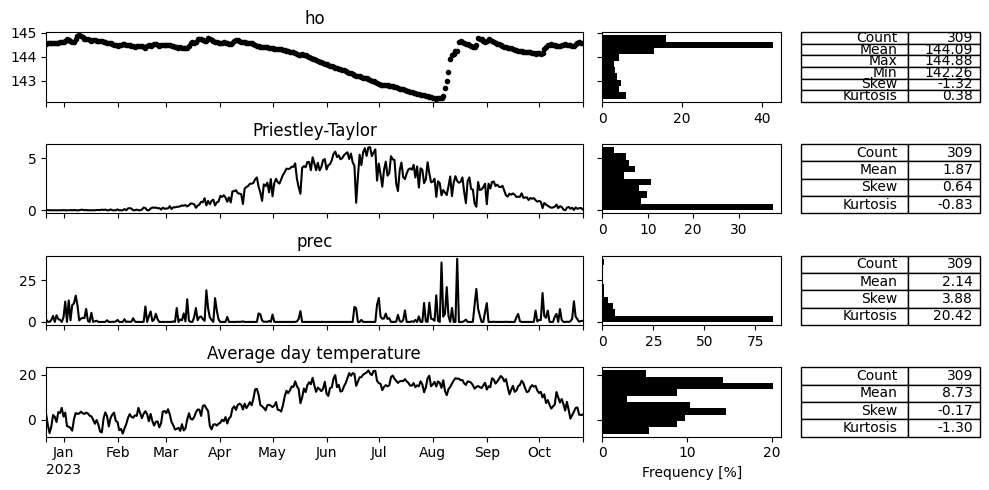

In [9]:
ps.plots.series(ho, stresses=[evap_selected, prec, temp], table=True)

The idea is to create two models and compare the results.

In [10]:
# Model 1: Without snow

# Model settings
tmin = pd.Timestamp("1996-01-01")  # Needs warmup
tmax = pd.Timestamp("2024-01-31")

# Create a model object by passing it the observed series
ml1 = ps.Model(ho, name="no_snow")

# Select a recharge model
rm1 = ps.rch.FlexModel(gw_uptake=True)
# rch = ps.rch.Berendrecht()
# rch = ps.rch.Linear()
# rch = ps.rch.Peterson()

sm1 = ps.RechargeModel(
    prec, 
    evap_selected, 
    recharge=rm1, 
    rfunc=ps.Gamma(), 
    name="rch"
)

ml1.add_stressmodel(sm1)

# As the evaporation used is a very rough estimation, vary k_v
ml1.set_parameter("rch_kv", vary=True)                              #CHECK

c:\Users\jmag\AppData\Local\anaconda3\envs\masters-thesis\Lib\site-packages\pastas\timeseries_utils.py:90: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  if hasattr(offset, "delta"):
c:\Users\jmag\AppData\Local\anaconda3\envs\masters-thesis\Lib\site-packages\pastas\timeseries_utils.py:90: FutureWarning: Day.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  if hasattr(offset, "delta"):
INFO: Time Series 'Priestley-Taylor': 422 nan-value(s) was/were found and filled with: interpolate.
c:\Users\jmag\AppData\Local\anaconda3\envs\masters-thesis\Lib\site-packages\pastas\stressmodels.py:1302: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  if self.prec.series.resample("A").sum().max() < 12:
INFO: Time Series 'Priestley-Taylor': 422 nan-value(s) was/were found and filled with: interpolate.


In [ ]:
# ONE-STEP SOLVE
ml1.solve(
    tmin=tmin,
    tmax=tmax,
    noise=False,
    fit_constant=False,         #CHECK
    report=False,
    solver=ps.LeastSquares()
)

# Plot
ml1.plot(figsize=(12, 6))

INFO: Time Series 'Priestley-Taylor': 422 nan-value(s) was/were found and filled with: interpolate.


<Axes: title={'center': 'Results of no_snow'}, xlabel='Date/time', ylabel='Groundwater levels [meter]'>

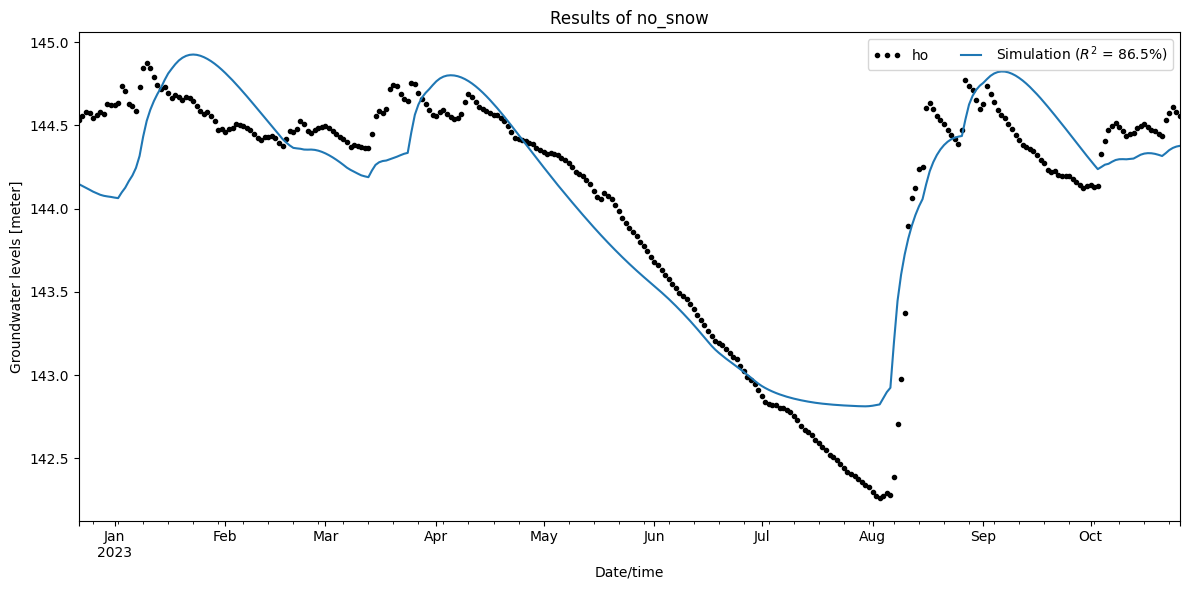

In [11]:
# TWO-STEP SOLVE

# Step 1
ml1.solve(
    tmin=tmin,
    tmax=tmax,
    noise=False,
    fit_constant=False,         #CHECK
    report=False,
    solver=ps.LeastSquares()
)

ml1.set_parameter("rch_srmax", vary=False)

# Step 2
ml1.solve(
    tmin=tmin,
    tmax=tmax,
    noise=True,
    fit_constant=False,         #CHECK
    initial=False,
    report=False,
    solver=ps.LeastSquares()
)

# Plot
ml1.plot(figsize=(12, 6))

[<Axes: xlabel='Date/time'>,
 <Axes: xlabel='Date/time'>,
 <Axes: title={'right': "Stresses: ['prec', 'Priestley-Taylor']"}>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=8)'}>]

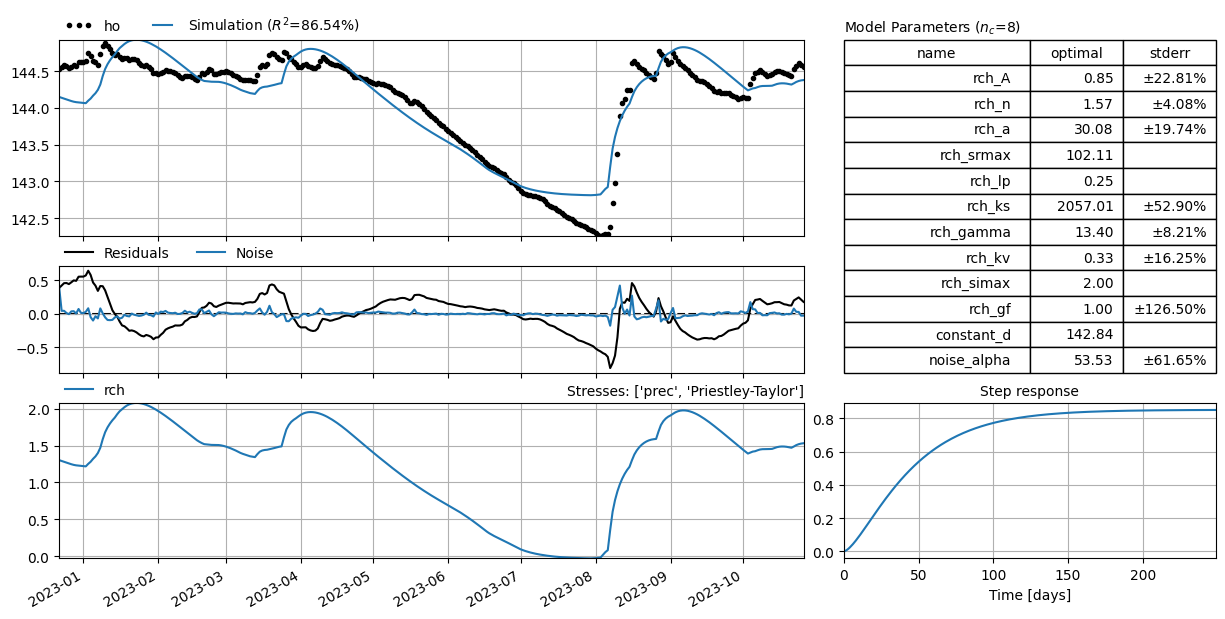

In [12]:
ml1.plots.results(figsize=(12, 6))

In [ ]:
# Model 2: With snow

# Model settings
tmin = pd.Timestamp("1996-01-01")  # Needs warmup
tmax = pd.Timestamp("2024-01-31")

# Create a model object by passing it the observed series
ml2 = ps.Model(ho, name="snow")

# Select a recharge model
rm2 = ps.rch.FlexModel(snow=True, gw_uptake=True)
# rch = ps.rch.Berendrecht()
# rch = ps.rch.Linear()
# rch = ps.rch.Peterson()

sm2 = ps.RechargeModel(
    prec,
    evap_selected,
    recharge = rm2,
    rfunc=ps.Gamma(),
    name="rch",
    temp=temp
)

ml2.add_stressmodel(sm2)

# As the evaporation used is a very rough estimation, vary k_v
ml2.set_parameter("rch_kv", vary=True)                              #CHECK

In [ ]:
# ONE-STEP SOLVE

# Step 1
ml2.solve(
    tmin=tmin,
    tmax=tmax,
    noise=False,
    fit_constant=False,     #CHECK
    report=False,
    solver=ps.LeastSquares()
)

# Plot
ml2.plot(figsize=(12, 6))

In [ ]:
# TWO-STEP SOLVE

# Step 1
ml2.solve(
    tmin=tmin,
    tmax=tmax,
    noise=False,
    fit_constant=False,     #CHECK
    report=False,
    solver=ps.LeastSquares()
)

ml2.set_parameter("rch_srmax", vary=False)

# Step 2
ml2.solve(
    tmin=tmin,
    tmax=tmax,
    noise=True,
    fit_constant=False,    #CHECK
    initial=False,
    report=False,
    solver=ps.LeastSquares()
)

# Plot
ml2.plot(figsize=(12, 6))

In [ ]:
# Compare results

# ml1: Without snow
# ml2: With snow

ax = ml2.plot(figsize=(12, 6))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "Model w Snow NSE={:.2f}".format(ml2.stats.nse()),
        "Model w/o Snow NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)
ax.grid(True)

In [ ]:
ml2.plots.results(figsize=(12, 6))